!pip install pandas numpy matplotlib seaborn scikit-learn openpyxl

# ✈️ Flight Cancellation Predictor based on Weather Conditions
This notebook processes historical flight and weather data to predict flight cancellations using machine learning.

In [1]:
import pandas as pd
import os
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
import requests

# OpenWeatherMap API endpoint and key
API_KEY = '2495e8ff5c7ba6e4eda282a59017524c'  # Replace with your actual API key
BASE_URL = "http://api.openweathermap.org/data/2.5/weather"

# Function to fetch and map weather data from API
def fetch_weather_data(city_name):
    params = {
        'q': city_name,  # City name
        'appid': API_KEY,  # Your API key
        'units': 'metric'  # To get temperature in Celsius
    }
    
    response = requests.get(BASE_URL, params=params)
    data = response.json()
    
    if response.status_code == 200:
        # Extract necessary weather data and map to your columns
        weather_data = {
            'HourlyWindSpeed_x': data['wind']['speed'],  # Wind speed in m/s
            'HourlyVisibility_x': data['visibility'] / 1000,  # Visibility in km
            'HourlyPrecipitation_x': data.get('rain', {}).get('1h', 0),  # Rain in the last hour (in mm)
            'HourlyDryBulbTemperature_x': data['main']['temp'],  # Temperature in Celsius
        }
        return weather_data
    else:
        print(f"Error fetching data for {city_name}: {data.get('message', '')}")
        return None


## 📁 Load and Combine Monthly Excel Files

In [3]:
# Define data directory
data_dir = r"C:/Users/Lenovo/FlightAI/"
csv_files = glob(os.path.join(data_dir, "*.csv"))

# Preview to ensure files were detected
print(f"Found {len(csv_files)} files.")

# Process each file one-by-one (without keeping all of them in memory)
sampled_chunks = []

for file in csv_files:
    try:
        # Read in chunks, or take a small sample if memory is tight
        chunk = pd.read_csv(file, nrows=1000)  # adjust nrows as needed
        print(f"Loaded {file} with shape {chunk.shape}")
        sampled_chunks.append(chunk)
    except Exception as e:
        print(f"Error loading {file}: {e}")

# Combine small chunks for preview and testing
if sampled_chunks:
    df = pd.concat(sampled_chunks, ignore_index=True)
    print(f"Final combined sample shape: {df.shape}")
    display(df.head())
    
    weather_cancelled = df[
        (df['delay_weather'] > 30) |
        (df['HourlyVisibility_x'] < 2.0) |
        (df['HourlyPrecipitation_x'] > 0.3) |
        (df['HourlyWindSpeed_x'] > 30)
    ].copy()

    # Duplicate them to boost their presence
    df = pd.concat([df, weather_cancelled]*2, ignore_index=True)
    
else:
    print("No data was successfully loaded.")


Found 9 files.
Loaded C:/Users/Lenovo/FlightAI\05-2019.csv with shape (1000, 35)
Loaded C:/Users/Lenovo/FlightAI\06-2019.csv with shape (1000, 35)
Loaded C:/Users/Lenovo/FlightAI\07-2019.csv with shape (1000, 35)
Loaded C:/Users/Lenovo/FlightAI\08-2019.csv with shape (1000, 35)
Loaded C:/Users/Lenovo/FlightAI\09-2019.csv with shape (1000, 35)
Loaded C:/Users/Lenovo/FlightAI\10-2019.csv with shape (1000, 35)
Loaded C:/Users/Lenovo/FlightAI\11-2019.csv with shape (1000, 35)
Loaded C:/Users/Lenovo/FlightAI\12-2019.csv with shape (1000, 35)
Loaded C:/Users/Lenovo/FlightAI\feature_importance.csv with shape (25, 2)
Final combined sample shape: (8025, 37)


,carrier_code,flight_number,origin_airport,destination_airport,date,scheduled_elapsed_time,tail_number,departure_delay,arrival_delay,delay_carrier,...,HourlyVisibility_x,HourlyWindSpeed_x,STATION_y,HourlyDryBulbTemperature_y,HourlyPrecipitation_y,HourlyStationPressure_y,HourlyVisibility_y,HourlyWindSpeed_y,Feature,Importance
0,AS,121.0,SEA,ANC,2019-05-01,215.0,N615AS,-8.0,-16.0,0.0,...,10.0,8.0,7.027253e+10,42.0,0.0,30.16,10.0,3.0,NaN,NaN
1,F9,402.0,LAX,DEN,2019-05-01,147.0,N701FR,17.0,-4.0,0.0,...,10.0,3.0,7.256500e+10,34.0,0.0,24.43,4.0,0.0,NaN,NaN
2,F9,662.0,SFO,DEN,2019-05-01,158.0,N346FR,44.0,27.0,0.0,...,10.0,6.0,7.256500e+10,34.0,0.0,24.43,4.0,0.0,NaN,NaN
3,F9,790.0,PDX,DEN,2019-05-01,156.0,N332FR,24.0,10.0,0.0,...,10.0,0.0,7.256500e+10,34.0,0.0,24.43,4.0,0.0,NaN,NaN
4,AS,108.0,ANC,SEA,2019-05-01,210.0,N548AS,-9.0,-31.0,0.0,...,10.0,5.0,7.279302e+10,44.0,0.0,29.58,10.0,7.0,NaN,NaN


In [4]:
# Drop unnecessary columns
columns_to_drop = [
    'flight_number', 'tail_number', 'date', 'cancelled_code',
    'scheduled_departure_dt', 'scheduled_arrival_dt',
    'actual_departure_dt', 'actual_arrival_dt',
    'STATION_x', 'STATION_y'
]


df = df.drop(columns=columns_to_drop, errors='ignore')
print(f"Remaining columns: {df.columns.tolist()}")


Remaining columns: ['carrier_code', 'origin_airport', 'destination_airport', 'scheduled_elapsed_time', 'departure_delay', 'arrival_delay', 'delay_carrier', 'delay_weather', 'delay_national_aviation_system', 'delay_security', 'delay_late_aircarft_arrival', 'year', 'month', 'day', 'weekday', 'HourlyDryBulbTemperature_x', 'HourlyPrecipitation_x', 'HourlyStationPressure_x', 'HourlyVisibility_x', 'HourlyWindSpeed_x', 'HourlyDryBulbTemperature_y', 'HourlyPrecipitation_y', 'HourlyStationPressure_y', 'HourlyVisibility_y', 'HourlyWindSpeed_y', 'Feature', 'Importance']


In [5]:
# Create 'Cancelled' column with nuanced logic
df['Cancelled'] = (
    (df['departure_delay'] > 240) |
    (df['delay_weather'] > 30) |
    (df['HourlyVisibility_x'] < 2.0) |
    (df['HourlyPrecipitation_x'] > 0.3) |
    (df['HourlyWindSpeed_x'] > 30)
).astype(int)

X = df.drop(columns=['Cancelled'])
y = df['Cancelled']


## 🧹 Clean and Prepare Data

In [6]:
# Drop rows with too many missing values
df.dropna(thresh=len(df.columns) * 0.7, inplace=True)

# Fill or drop remaining NAs
df.dropna(inplace=True)

# Encode categorical columns
le = LabelEncoder()
for col in df.select_dtypes(include='object').columns:
    df[col] = le.fit_transform(df[col])


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# One-hot encode first
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

# Align columns in case of mismatch
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Scale features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Drop zero-variance columns
non_zero_var_cols = X_train_scaled.loc[:, X_train_scaled.std() > 0].columns
X_train_scaled = X_train_scaled[non_zero_var_cols]
X_test_scaled = X_test_scaled[non_zero_var_cols]



In [8]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [9]:
from treeinterpreter import treeinterpreter as ti
import numpy as np
import pandas as pd

# Choose any test instance to explain
sample_index = 0
sample_instance = X_test.iloc[[sample_index]]  # 2D for model input

# Get prediction, bias, and contributions
prediction, bias, contributions = ti.predict(model, sample_instance)

# Extract values
feature_names = sample_instance.columns
feature_values = sample_instance.iloc[0].values  # 1D array
contribution_values = contributions[0][:, 1]

# Build the DataFrame
contrib_df = pd.DataFrame({
    'Feature': feature_names,
    'Value': feature_values,
    'Contribution': contribution_values
})

# Sort by absolute contribution
contrib_df['AbsContribution'] = contrib_df['Contribution'].abs()
contrib_df.sort_values(by='AbsContribution', ascending=False, inplace=True)

# Display
print("Predicted class probabilities:", prediction)
print("Bias (base value):", bias)
print("Feature contributions:")
display(contrib_df[['Feature', 'Value', 'Contribution']])


c:\Users\Lenovo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X h

Predicted class probabilities: [[0.01 0.99]]
Bias (base value): [[0.92710594 0.07289406]]
Feature contributions:


c:\Users\Lenovo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X h

,Feature,Value,Contribution
15,HourlyVisibility_x,0.25,0.648209
97,origin_airport_CMH,True,0.130333
14,HourlyStationPressure_x,29.03,0.064266
12,HourlyDryBulbTemperature_x,61.0,0.027779
11,weekday,5.0,0.019865
...,...,...,...
133,origin_airport_EVV,False,0.000000
28,carrier_code_G4,False,0.000000
132,origin_airport_EUG,False,0.000000
131,origin_airport_ERI,False,0.000000


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3074
           1       1.00      1.00      1.00       244

    accuracy                           1.00      3318
   macro avg       1.00      1.00      1.00      3318
weighted avg       1.00      1.00      1.00      3318



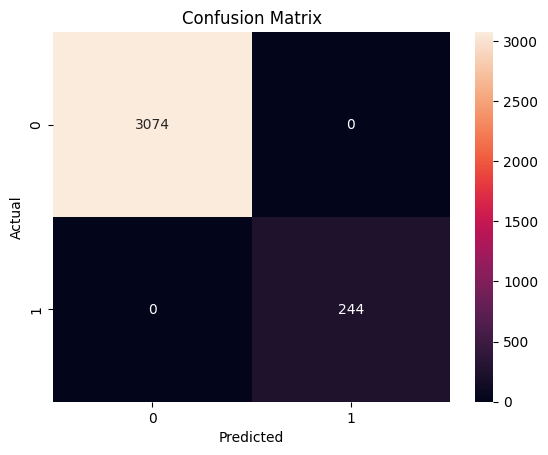

In [10]:
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


## ✈️ Model Explainability and Confidence Analysis

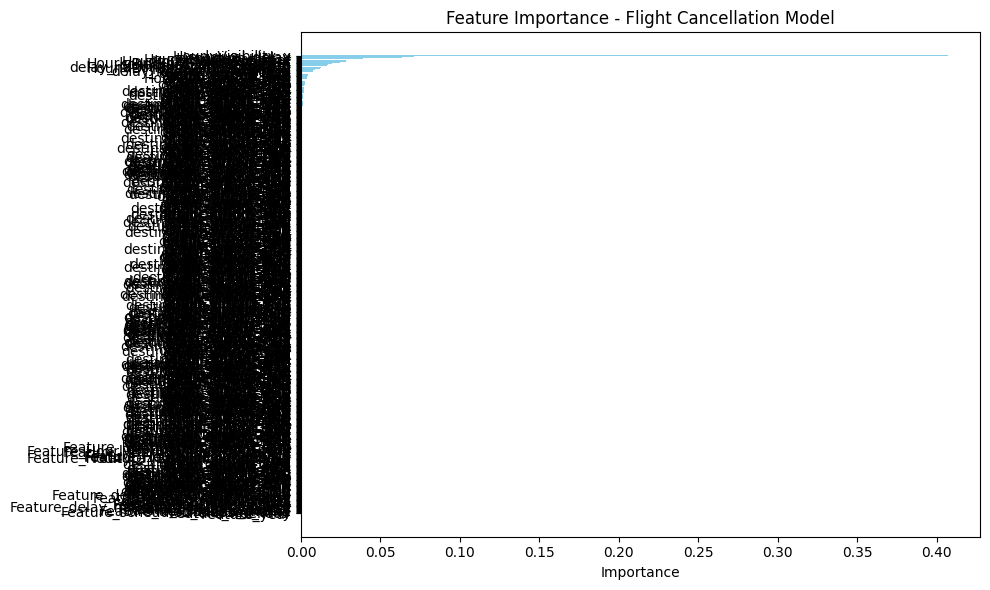

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

# Get feature importances
importances = model.feature_importances_
feature_names = X_train.columns

# Create a dataframe
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel("Importance")
plt.title("Feature Importance - Flight Cancellation Model")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [12]:
# Get prediction probabilities
y_proba = model.predict_proba(X_test)

# Create a confidence score summary
results = []

for i in range(len(X_test)):
    predicted_class = model.predict([X_test.iloc[i]])[0]
    confidence = y_proba[i][predicted_class]
    results.append({
        "Flight": i + 1,
        "Predicted Class": predicted_class,
        "Confidence Score": f"{confidence:.2%}"
    })

import pandas as pd
pd.DataFrame(results).head(10)  # Show top 10


c:\Users\Lenovo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python313\Lib\site-package

,Flight,Predicted Class,Confidence Score
0,1,1,99.00%
1,2,0,98.00%
2,3,0,100.00%
3,4,0,99.00%
4,5,0,100.00%
5,6,0,100.00%
6,7,0,100.00%
7,8,0,100.00%
8,9,0,99.00%
9,10,0,100.00%


In [13]:
import joblib

# Save model
joblib.dump(model, "flight_cancellation_model.pkl")

# Save the columns used during training
joblib.dump(X_train.columns.tolist(), "model_features.pkl")


['model_features.pkl']

In [14]:
# 9. Hard-coded “Not Cancelled” test example

# Step A: define one sample with your exact feature names
test_sample_good = {
    'carrier_code':                     ['DL'],      # Delta
    'origin_airport':                   ['JFK'],
    'destination_airport':              ['LAX'],
    'scheduled_elapsed_time':           [500],       # e.g. 5 hours
    'departure_delay':                  [0],         # no departure delay
    'arrival_delay':                    [0],         # no arrival delay
    'delay_carrier':                    [0],
    'delay_weather':                    [240],
    'delay_national_aviation_system':   [0],
    'delay_security':                   [0],
    'delay_late_aircarft_arrival':      [0],
    'year':                             [2019],
    'month':                            [7],
    'day':                              [15],
    'weekday':                          [1],         # Monday
    # origin airport weather features (_x suffix)
    'HourlyDryBulbTemperature_x':       [75.0],      # warm, clear
    'HourlyPrecipitation_x':            [0.0],       # no rain
    'HourlyStationPressure_x':          [1015.0],
    'HourlyVisibility_x':               [10.0],      # max visibility
    'HourlyWindSpeed_x':                [5.0],       # light breeze
    # destination airport weather features (_y suffix)
    'HourlyDryBulbTemperature_y':       [75.0],
    'HourlyPrecipitation_y':            [0.0],
    'HourlyStationPressure_y':          [1015.0],
    'HourlyVisibility_y':               [10.0],
    'HourlyWindSpeed_y':                [5.0],
}

# Step B: build DataFrame
test_df_good = pd.DataFrame(test_sample_good)

# Step C: one-hot encode & align
test_df_good = pd.get_dummies(
    test_df_good,
    columns=['carrier_code','origin_airport','destination_airport','weekday'],
    drop_first=True
)
test_df_good = test_df_good.reindex(columns=X_train.columns, fill_value=0)

# Step D: predict class + probability
pred_class = model.predict(test_df_good)[0]
pred_proba = model.predict_proba(test_df_good)[0,1]

print(f"Prediction (1=Cancelled): {pred_class}")
print(f"Confidence P(Cancelled=1): {pred_proba:.2%}")


Prediction (1=Cancelled): 0
Confidence P(Cancelled=1): 37.00%
